### Librerías

In [1]:
import io
import os
import sys
import pickle
import tarfile
import urllib

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.transforms.functional as TF
from tqdm import tqdm
from pathlib import Path

### Cargando el modelo

In [3]:
# ruta a tu repo local de DINOv3
DINOV3_LOCAL_PATH = r"C:\Users\linet\Project\dinov3"
sys.path.append(DINOV3_LOCAL_PATH)

# importar el modelo desde hub/backbones.py
from dinov3.hub.backbones import dinov3_vith16plus

# ruta al checkpoint que ya descargaste
checkpoint_path = r"C:\Users\linet\Project\model\dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth"

# crear el modelo vacío (sin pesos)
model = dinov3_vith16plus(pretrained=False)

# cargar el diccionario de pesos
state_dict = torch.load(checkpoint_path, map_location="cpu")

# pasar pesos al modelo
model.load_state_dict(state_dict)

# enviar a GPU
model = model.cuda()

In [5]:
print(model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-31): 32 x SelfAttentionBlock(
      (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (mlp): SwiGLUFFN(
        (w1): Linear(in_features=1280, out_features=5120, bias=True)
        (w2): Linear(in_features=1280, out_features=5120, bias=True)
        (w3): Linear(in_features=5120, out_features=1280, bias=True)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerNorm((

### Cargando imágenes

In [7]:
IMAGES_FOLDER = "alas_png"

def load_images_from_folder(folder_path: str):
    folder = Path(folder_path)
    return [Image.open(f).convert("RGB") for f in sorted(folder.glob("*.png"))]

images = load_images_from_folder(IMAGES_FOLDER)
print(f"Loaded {len(images)} images")

Loaded 298 images


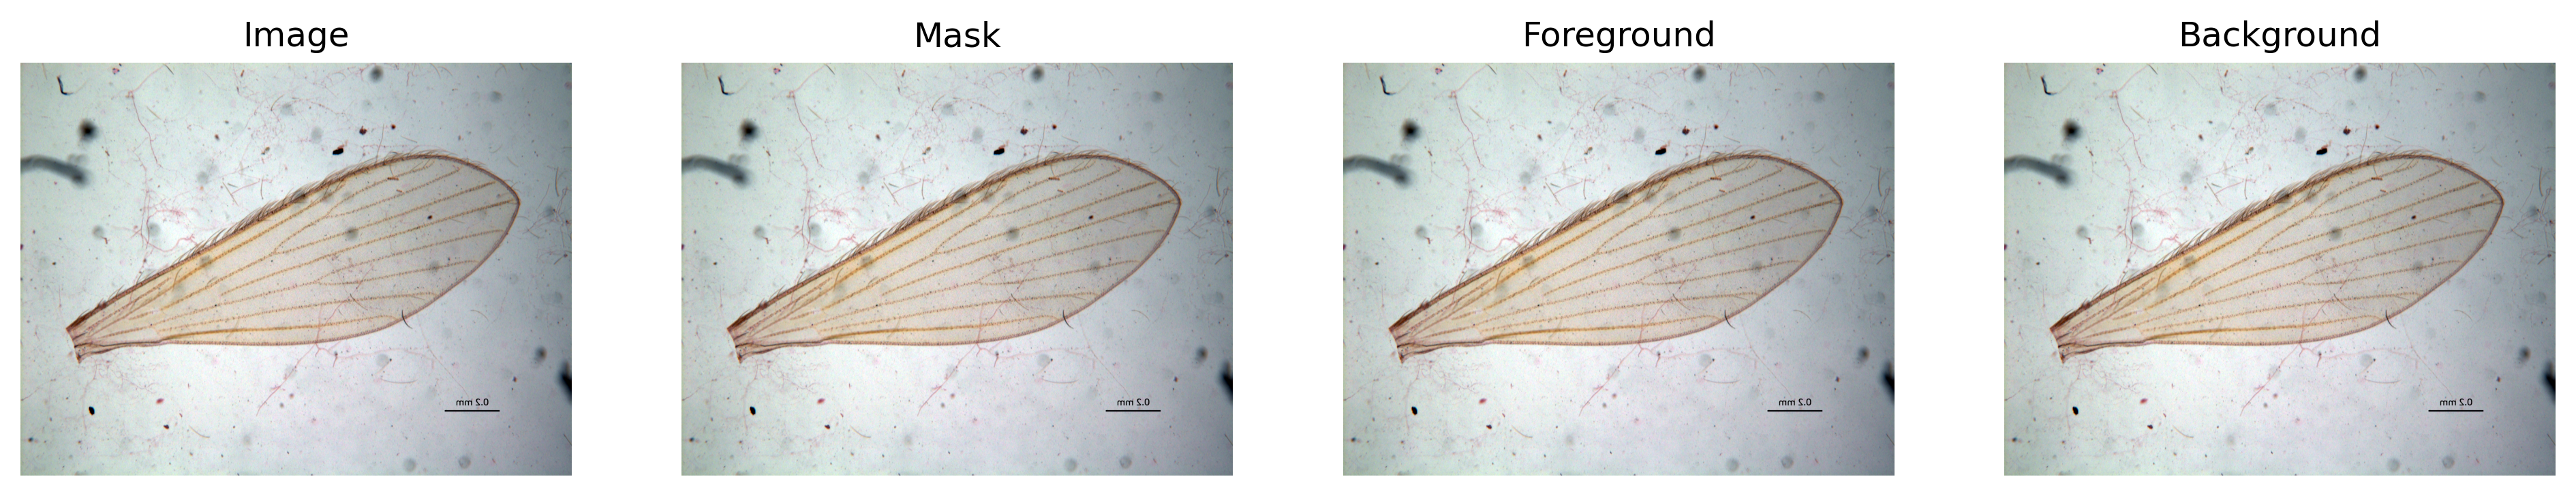

In [9]:
data_index = 0
image = images[data_index]

# Como no tienes máscaras, usamos la misma imagen como placeholder
mask = image
foreground = image
background = image

data_to_show = [image, mask, foreground, background]
data_labels = ["Image", "Mask", "Foreground", "Background"]

plt.figure(figsize=(16, 4), dpi=300)
for i in range(len(data_to_show)):
    plt.subplot(1, len(data_to_show), i + 1)
    plt.imshow(data_to_show[i])
    plt.axis('off')
    plt.title(data_labels[i], fontsize=12)
plt.show()